In [3]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [153]:
def trim_attack_fn(df):
    """In column "attack_fn" of dataframe df, remove all
    superfluous characters from the attack name, leaving only
    the attack name itself.
    """
    names = ["gaussian_attack", "lie_attack", "fang_attack", "minmax_attack"]
    # remove superfluous characters from attack names in df
    for name in names:
        df.loc[df["attack_fn"].str.contains(name), "attack_fn"] = name
    names = {"gaussian_attack": "GAUSS", "lie_attack": "LIE", "fang_attack": "OPT", "minmax_attack": "AGR-MM"}
    # rename attack names in df
    for name in names:
        df.loc[df["attack_fn"].str.contains(name), "attack_fn"] = names[name]
    return df

def dataset_name_cleaner(df):
    names = {"mnist": "MNIST", "cifar": "CIFAR-10", "income": "Income", "house": "California Housing"}
    for name in names:
        df.loc[df["dataset_name"].str.contains(name), "dataset_name"] = names[name]
    return df

def get_max_acc(df):
    """Return the maximum accuracy achieved in each experiment.
    """
    max_acc = df.sort_values(by='accuracy', ascending=False).groupby(['dataset_name', 'attack_fn', 'num_malicious']).first().reset_index()
    return max_acc

def add_missing_no_attacks(df):
    """To save time, I didn't run experiments with num_malicious = 0
    for all datasets. This function adds those missing rows to the
    dataframe.
    """
    df_lie = df.loc[df["num_malicious"] == 0].assign(attack_fn="LIE", ignore_index=True)
    df_opt = df.loc[df["num_malicious"] == 0].assign(attack_fn="OPT", ignore_index=True)
    df_agr = df.loc[df["num_malicious"] == 0].assign(attack_fn="AGR-MM", ignore_index=True)
    df = pd.concat([df, df_lie, df_opt, df_agr], ignore_index=True)
    return df

def compute_mape(x):
    """Flip MAPE values (i.e. 1 - MAPE) for the sake of representation.
    """
    if x['dataset_name'] == 'California Housing':
        return 1 - x['auc']
    return x['auc']

In [156]:
df = pd.read_csv('../results/all_results.csv')

df = trim_attack_fn(df)
df = dataset_name_cleaner(df)
df.auc = df.apply(compute_mape, axis=1)
# Swap auc (i.e. MAPE) column name with accuracy only for California Housing
df = df.rename(columns={"auc": "accuracy", "accuracy": "auc"})
df = df.drop(columns=["auc", "loss"])
df = get_max_acc(df)
df = add_missing_no_attacks(df)

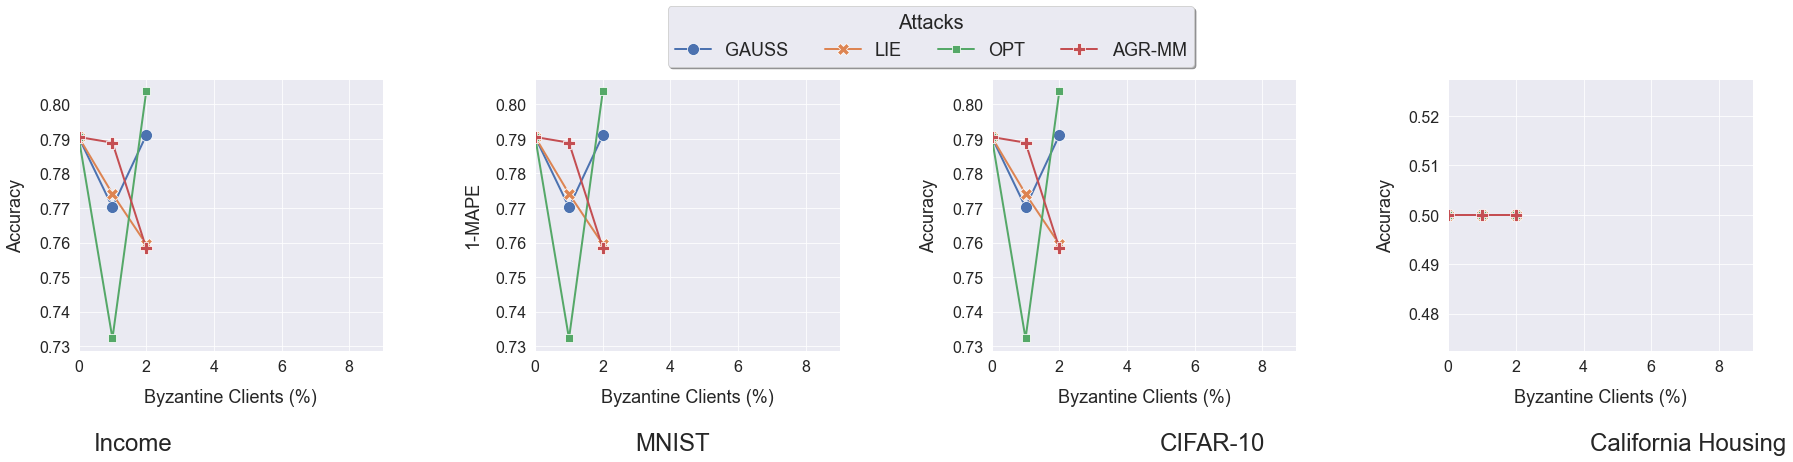

In [155]:
# Global settings
sns.set_theme()
sns.set_context("paper", font_scale=1.5)

dataset_names = ["MNIST", "CIFAR-10", "Income", "California Housing"]
attack_names = ["GAUSS", "LIE", "OPT", "AGR-MM"]

fig, axes = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(30, 5))

for i in range(len(dataset_names)):
    p = df.loc[df.dataset_name == dataset_names[i]]
    ax = sns.lineplot(data=p, x='num_malicious', y='accuracy', hue="attack_fn", ax=axes[i], 
                      style="attack_fn", markers=True, dashes=False, lw=2, markersize=12)
          
    _ = ax.tick_params(axis='both', which='major', labelsize=16)
        
    _ = ax.set_xlim([0,9])

    if i == 3:
        handles, lables = ax.get_legend_handles_labels()
        for h in handles:
            h.set_markersize(12)
            h.set_linewidth(2)

        # replace legend using handles and labels from above
        _ = ax.legend(handles,
                   attack_names,   
              title="Attacks",
              title_fontsize=20,
              fontsize=18, 
              loc='upper center', 
              bbox_to_anchor=(-1.7, 1.3), 
              ncol=4, 
              fancybox=True, 
              shadow=True)
    else:
        _ = ax.get_legend().remove() 

_ = axes[0].set_ylabel('Accuracy', labelpad=14, fontsize=18)
_ = axes[1].set_ylabel('1-MAPE', labelpad=14, fontsize=18)
_ = axes[2].set_ylabel('Accuracy', labelpad=14, fontsize=18)
_ = axes[3].set_ylabel('Accuracy', labelpad=14, fontsize=18)
_ = axes[0].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)
_ = axes[1].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)
_ = axes[2].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)
_ = axes[3].set_xlabel('Byzantine Clients (%)', labelpad=14, fontsize=18)

plt.figtext(0.15,-0.1, "Income", ha="center", va="top", fontsize=24)
plt.figtext(0.4,-0.1, "MNIST", ha="center", va="top", fontsize=24)
plt.figtext(0.65,-0.1, "CIFAR-10", ha="center", va="top", fontsize=24)
plt.figtext(0.87,-0.1, "California Housing", ha="center", va="top", fontsize=24)

plt.subplots_adjust(wspace=0.5)